In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import imutils
import matplotlib.gridspec as gridspec

MODEL_DICT = 'model.pth'

# Auxiliary functions

In [6]:
def show(crop_characters: list, cmap: str = "gray") -> None:
    """Displays a list of images side-by-side"""

    if len(crop_characters) != 0:
        fig = plt.figure(figsize=(10,5), constrained_layout=True)
        grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

        for i in range(len(crop_characters)):
            fig.add_subplot(grid[i])
            plt.axis(False)
            plt.imshow(crop_characters[i], cmap=cmap)

def get_data(path: str) -> list:
    """Returns an iterator with paths to each image to be detected"""

    imgs = os.listdir(path)
    return sorted([f"{path}/{img}" for img in imgs])

def box_of_points(points: list) -> tuple:
    """Returns the biggest box from a series of points. Returns x_max, x_min, y_max, y_min"""

    return max(points,key=lambda x: x[0])[0], min(points,key=lambda x: x[0])[0], \
           max(points,key=lambda x: x[1])[1], min(points,key=lambda x: x[1])[1]

def sort_contours(cnts, reverse = False):
    i = 0
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    cnts, _ = zip(*sorted(zip(cnts, bounding_boxes), key=lambda b: b[1][i], reverse=reverse))
    return cnts

def set_angle(angle: float):
    """Converts any angle to +-45 degrees"""

    if -45 < angle < 45:
        rotation = angle
    elif angle < -45:
        rotation = 90 + angle
    else:
        rotation = 90 - angle

    return rotation

In [7]:
data = get_data("data")
len(data)

59

# Plate detection

This class extracts characters from the images

In [44]:
class PlateLocator(object):

    __slots__ = ['size', 'kernel_size', 'sigma_color', 'sigma_space', 'keep_hulls', 'wh_ratio', 'digit_size']

    def __init__(self, size:tuple = (620, 480), kernel_size:tuple = (5, 5), sigma_color: int = 200,
                 sigma_space:int = 150, keep_hulls:int = 10, wh_ratio:tuple = (1.5, 3.5), digit_size: tuple = (30, 60)) -> None:

        self.size = size
        self.kernel_size = kernel_size
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space
        self.keep_hulls = keep_hulls
        self.wh_ratio = wh_ratio
        self.digit_size = digit_size

    def process(self, image: str, display: bool = False) -> list:
        processed, original = self._preprocess(image)
        hulls = self._hulls(processed)

        plates = []

        for candidate in hulls:
            valid, plate = self._evaluate_candidate(candidate, original)
            if valid: plates.append(plate)

        if display: show([processed, original]); show(plates)

        return plates

    def numbers(self, candidate: np.ndarray, display: bool = False):
        image_res = cv2.cvtColor(candidate, cv2.COLOR_BGR2GRAY)
        image =  cv2.threshold(image_res, 110, 255, cv2.THRESH_BINARY_INV)[1]

        output = cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S)

        num_labels, _, stats, _ = output

        numbs = list()

        if display:
            roi = candidate.copy()
            background = 255 * image.copy().astype(np.int8)

        for i in range(num_labels):
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]

            if display:
                cv2.rectangle(roi, (x-1, y-1), (x+w+1, y+h+1), (0, 255, 0), 1)

            # Remove labels that are too small or have points outside the candidate
            if x > 1 and y > 1 and h > 20 and h > w and x+w < candidate.shape[1] and y+h < candidate.shape[0]:
                numb = image[y-1:y+h+1, x-1:x+w+1]
                numb = cv2.resize(numb, self.digit_size, cv2.INTER_NEAREST)
                numbs.append((numb, x))

                if display:
                    cv2.rectangle(roi, (x-1, y-1), (x+w+1, y+h+1), (250, 0, 0), 1)
                    cv2.rectangle(background, (x-1, y-1), (x+w+1, y+h+1), (255, 255, 255), 1)

        if display and len(numbs) > 6: show([roi, background]); show([x[0] for x in sorted(numbs, key=lambda x: x[1])])

        return [x[0] for x in sorted(numbs, key=lambda x: x[1])]

    def get_dataset(self, data_folder: list, total: int = -1):
        cooked_data = list()

        for img in data_folder[:total]:
            cooked_data.append([self.numbers(area) for area in self.process(img) if len(self.numbers(area)) > 6])

        print(f"[INFO] Loaded {len(cooked_data)} images")
        print(f"[INFO] Located {sum([len(x) for x in cooked_data])} plates")
        print(f"[INFO] Detected {sum([sum([len(y) for y in x]) for x in cooked_data])} characters")
        return cooked_data

    def _preprocess(self,filepath: str):
        image = cv2.imread(filepath)
        image = cv2.resize(image, self.size)
        image2 = cv2.bilateralFilter(image.copy(), self.kernel_size[0], self.sigma_color ,self.sigma_space)
        image_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        return cv2.dilate(cv2.Canny(image_gray, 0, 255), np.ones((3, 2), np.uint8)), cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def _hulls(self, image: np.ndarray = None):
        contours = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:self.keep_hulls]

        return [cv2.convexHull(contour) for contour in contours]

    def _evaluate_candidate(self, candidate, image: np.ndarray):
        rect = cv2.minAreaRect(candidate)
        box = np.int0(cv2.boxPoints(rect))
        points = box_of_points(box)

        if all([x > 0 for x in [point for point in points]]):
            x_0, x_1, y_0, y_1 = points
            w,h = y_0-y_1 , x_0-x_1
            if self.wh_ratio[0] < h/w < self.wh_ratio[1]:
                plate = image[y_1:y_0, x_1:x_0]
                return True, plate

        return False, None

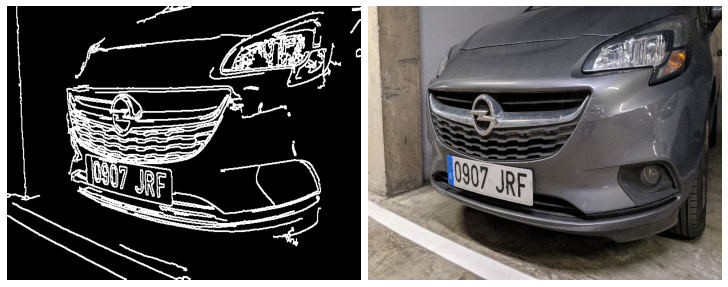

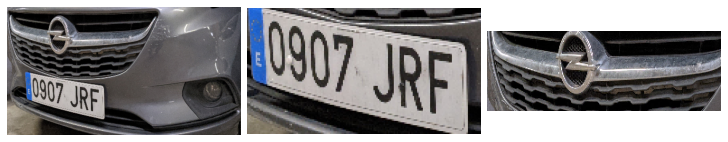

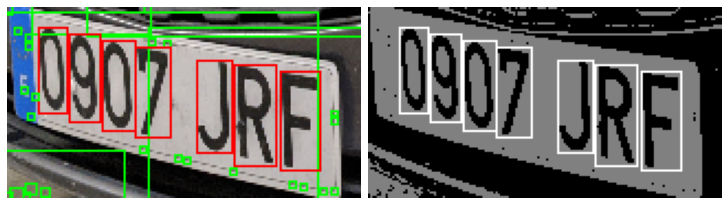

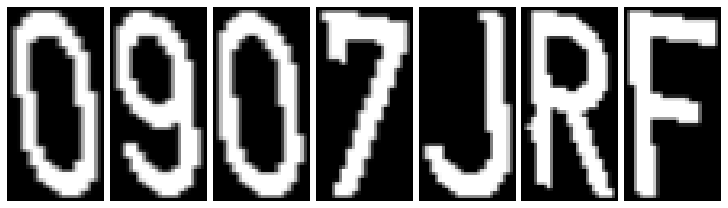

In [45]:
proc = PlateLocator().process(data[5], True)
numb = PlateLocator().numbers(proc[1], True)